Данный ноутбук был составлен после нескольких десятков попыток достичь высокого результата при работе над обучением модели распознавания базы MNIST "попиксельно". Однако, имея мало свободного времени на тренировки, не упел найти хорошие гиперпараметры моделей: самый перспективный на первый взгляд SVC тренировался очень медленно и часто выдавал единственное прогнозируемое значение. "Случайный лес" хорошо показал себя на тренировочной выборке, но на тестовой давал результаты хуже на 20-30%. Параметры, уменьшающие переобучение, быстро подобрать не удалось. Лучшая точность была 0.62 на Random Forest (при квантовании изображения в черное и белое и выбраковке неиформативных признаков). Ссылка на предыдущие попытки: 

В задаче не было условий на предобработку входящих данных. Учитвая то, что выборки MNIST не умеют шума в фоне и приведены в 8 битную ч/б палитру, воспользусь этим и попробую векторизовать рукописный ввод. Векторизация позволит значительно снизить количество признаков, при этом по-максимуму сохранив информацию о символах ввода. Так так скорость предобработки изображений по условиям соревнования не ограничена, попробую найти решение векторизации "в лоб".

In [1]:
!pip install -U kaggle scikit-learn==1.0 scikit-image geopandas shapely

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
!touch /content/kaggle.json
!chmod 600 /content/kaggle.json

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
api_token = {'username': 'rafaelkamashev', 'key': 'e6891d0b2b04d3bd70bcc194f6157081'}

with open('/content/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [ ]:
!kaggle competitions download -c jds3 --force

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import json
import os
import string

import geopandas as gpd
from shapely.geometry import Polygon, LineString
from skimage.morphology import skeletonize
from skimage.filters import gaussian
from skimage.transform import probabilistic_hough_line
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.model_selection._search_successive_halving import HalvingGridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
'imported'

'imported'

In [2]:
# грузим тестовый набор
test_df = pd.read_csv('jds3/emnist-letters-test-sh.csv', header=None).values
test_df.shape

(14800, 784)

In [3]:
# грузим тренировочный набор
train_df = pd.read_csv('jds3/emnist-letters-train.csv.zip', header=None)
train_df.shape

(88800, 785)

In [4]:
# отделяем 
y, X = train_df[0].values, train_df.drop(0, axis=1)
X.rename(columns={col + 1: col for col in (X.columns - 1)}, inplace=True)
(y.shape, X.shape)

((88800,), (88800, 784))

In [5]:
alphabet = list(string.ascii_lowercase)
string.ascii_lowercase

'abcdefghijklmnopqrstuvwxyz'

Y = f, idx = 13892
lines: [((3, 16), (11, 15)), ((12, 9), (17, 5)), ((12, 14), (17, 14)), ((12, 17), (15, 14)), ((12, 23), (12, 16)), ((18, 4), (23, 3))] 

CPU times: user 68.6 ms, sys: 4.03 ms, total: 72.6 ms
Wall time: 67 ms


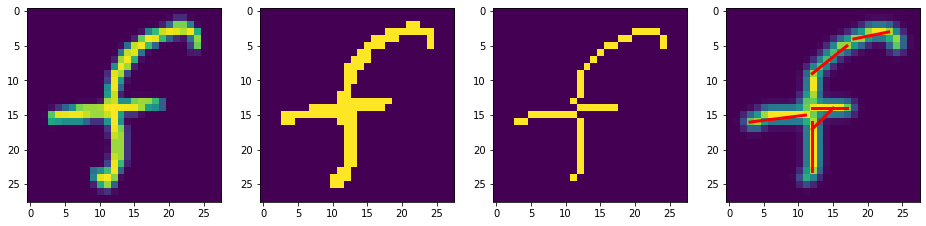

In [102]:
%%time
# эксперимент по векторизации изображения
# (промежуточные результаты удалены, описание алгоритма в ячейке ниже):
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 5))

idx = np.random.randint(0, X.shape[0])
print(f'Y = {alphabet[y[idx] - 1]}, idx = {idx}')
pixels = np.copy(X.loc[idx].values)
ax1.imshow(pixels.reshape(28, 28).T)


edge = 128
pixels[pixels < edge] = 0
pixels[pixels >= edge] = 1

img = pixels.reshape(28, 28).T
ax2.imshow(img)

img = skeletonize(img, method='lee')
lines = probabilistic_hough_line(img, threshold=2, line_length=3, line_gap=2)
ax3.imshow(img)

sigma = .75
img = gaussian(
    img, sigma=(sigma, sigma), cval=1, preserve_range=True
)
ax4.imshow(img)

# сортируем слева направо, сверху вниз
lines.sort(key=lambda x: (x[0][0], x[0][1]))
print('lines:', lines, '\n')

for line in lines:
    (x1, y1), (x2, y2) = line
    ax4.plot((x1, x2), (y1, y2), 'r-', linewidth=3.)

Минусом данного алгоритма является довольно медленная обработка и нестабильность алгоритма поиска векторов (не идемпотентен)

In [6]:
# оформлю в виде функции
def img_vectors(sample):
    """Векторизация изображения рукописного ввода. Возвращает набор векторов"""
    pixels = np.copy(sample)

    # переводим в черное-белое
    pixels[pixels < 128] = 0
    pixels[pixels >= 128] = 1
    img = pixels.reshape(28, 28).T

    # очень медленный, но довольно эффективный метод преобразование линий рукописного ввода 
    # в однопиксельную линию (чем уже линия, тем меньше помех)
    img = skeletonize(img)

    # извлечение векторов
    vects = probabilistic_hough_line(img, threshold=1, line_length=3, line_gap=2)

    # сортируем сверху вниз,слева направо
    vects.sort(key=lambda x: (x[0][1], x[0][0]))
    return vects

In [7]:
%%time
# извлечем все вектора тренировочной выборки
x_vectors = [img_vectors(row) for row in X.values]
print('total:', len(x_vectors), ', mean lines count:', np.mean([len(x) for x in x_vectors]))
print('Ex:', x_vectors[101], '\n')

total: 88800 , mean lines count: 5.907691441441441
Ex: [((19, 6), (21, 3)), ((18, 8), (20, 5)), ((11, 11), (10, 7)), ((16, 12), (18, 9)), ((9, 21), (17, 10))] 

CPU times: user 25.5 s, sys: 166 ms, total: 25.7 s
Wall time: 25.7 s


На весь тренировочный набор уходит около 30 секунд. Теперь было бы еще неплохо получить статистику из векторов обучающих примеров

In [8]:
def img_stats(*vectors):
    """Извлечение обобщенных метрик геометрии векторов"""

    vectors = np.array(vectors)
    intervals = np.linspace(-1, 1., 8)

    stats = []
    for vector in vectors:
        (x1, y1), (x2, y2) = vector
        abs_x, abs_y, dx, dy = np.abs(x1 - x2), np.abs(y1 - y2), x1 - x2, y1 - y2
        length = np.sqrt(abs_x**2 + abs_y**2)
        stats.append({
            'x1': x1, 'y1': y1,
            'len': length,
            'sin': dy / length,
            'ltr': 1. if dx > 0 else -1,
            'dx': dx, 'dy': dy, 'abs_x': abs_x, 'abs_y': abs_y
        })

    # счетчики длин по диапазонам углов наклонов 
    angle_counts = [
        sum(1 for i in stats if gte <= i['sin'] * i['ltr'] < lt)
        for gte, lt in zip(intervals, intervals[1:])
    ]
    return np.array([
        len(stats),  # общее количество линий
        sum(x['abs_x'] for x in stats),  # сумма проекций по X
        sum(y['abs_y'] for y in stats),  # сумма проекций по Y
    ] + angle_counts, dtype=np.float32)

In [ ]:
%%time
X_stats = np.array([img_stats(*vectors) for vectors in x_vectors])
print('Ex:', X_stats[101], '\n')
X_stats.shape

Базовая статистика получена. Но не хватает информации о "фигуре" векторизованного изображения. Дабы решить эту задачу, попробую рассчитать отрезки векторов в рамках 4 квадратов, на которые поделю исходную плоскость. Затем попробую рассчитать сумму векторов в рамках каждой области, что даст по 4 координаты в каждой области и дополнительно 16 признаков, отражающих внешний вид изображения в каждой четверти.

In [10]:
def split_squares(w, N=4):
    """
    Функция вернет координаты N квадратных полигонов,
    на которые будет разбит исходный квадрат
    """

    n = int(np.sqrt(N))
    d = w / n
    r = d / 2
    c = [i*d+d/2 for i in range(n)]
    centers = np.array([[(x, y) for x in c] for y in c]).reshape(-1, 2)

    return np.array([
        ((x-r, y-r), (x+r, y-r), (x+r, y+r), (x-r, y+r), (x-r, y-r)) 
        for x, y in centers
    ])

In [11]:
squares = split_squares(28, 4)
square_gdf = [gpd.GeoDataFrame(geometry=[Polygon(p)]) for p in squares]
square_gdf

[                                            geometry
 0  POLYGON ((0.00000 0.00000, 14.00000 0.00000, 1...,
                                             geometry
 0  POLYGON ((14.00000 0.00000, 28.00000 0.00000, ...,
                                             geometry
 0  POLYGON ((0.00000 14.00000, 14.00000 14.00000,...,
                                             geometry
 0  POLYGON ((14.00000 14.00000, 28.00000 14.00000...]

In [15]:
# опишу функцию, которая вернет вектор внутри каждого квадрата
def get_mean_vectors(vectors, square_gdf):
    summaries = []
    for sq in square_gdf:
        summary = np.zeros(4, dtype=np.float32)
        occ = 0
        for vector in vectors:
            vector_gdf = gpd.GeoDataFrame(geometry=[LineString(vector)])
            intersection = vector_gdf.intersection(sq)

            for intersect in intersection.values.data:
                coords = [x for x in intersect.coords]
                if len(coords) == 2:
                    coords = np.array(coords).reshape(4,)
                    summary = np.add(summary, coords)
                    occ += 1

        if not occ:
            occ += 1
        summaries.append(summary / occ)
    return np.array(summaries).reshape(16,)

In [ ]:
%%time
# попробую вызвать для одного из примеров тренировочной выборки
X_mean = np.array([get_mean_vectors(row, square_gdf) for row in x_vectors])
print(X_mean[101], '\n')
X_mean.shape

Получилось очень медленно, поэтому сохраню полученную матрицу в csv, а потом загружу из него. При последующих прогонах можно будет пропустить данный шаг данных.

In [ ]:
pd.DataFrame(X_mean).to_csv('vector_means.csv')

Теперь у нас есть общая статистика и усредненный вектор для 4 квадратов матрицы изображения. Теперь все признаки можно склеить вместе и приступить к обучению модели. Попробую для предварительной оценки реализовать "в лоб" модель на основе "случайного леса", так как она не потребует нормализации входных данных. 

In [ ]:
X_mean = pd.read_csv('vector_means.csv', header=None).values